# Tutorial for reflectance calculations with phase in the structural-color package

Copyright 2021

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Introduction to how phase is implemented in the package

When simulating the scattering of light waves, it's intuitive that we need to consider their phase. Keeping track of phase requires us to more deeply examine what each trajectory represents and how phase should be tracked. In our model, we sometimes refer to the light trajectories as photons, or photon packets. These descriptions, however, are not perfect metaphors for what we are actually modelling. A more intuitive way to think of them is as a packet of light that has both wave and particle qualities. Within one trajectory, we can track polarization, position, direction, and weight. The foundation of our model also means that we consider the interference that takes place within one trajectory. The calculation of the form and struture factor for each trajectory determines how constructive interference affects the path of the trajectory. 

But the foundation of our model ignores the interactions *between* the trajectories. That is, the interference between the different photons. In order to track potential interference effects between trajectories, we must keep track of the phase value of the trajectory as it scatters and moves through the structurally colored material. 

At first glance, one might argue that there is no need to consider the interference between trajectories. After all, we are using an incoherent light source. But this isn't quite true. The coherence length of many incoherent light sources is on the scale of tens of microns, and photons can travel shorter distances than that before exiting the sample. In addition, the fact that the structure factor leads to interference peaks offers proof that interference matters even when we have an incoherent light source. But then again, if most of the structure factor interference peak contributions come from single scattering, perhaps the interference only affects light in terms of the structure factor, which is already accounted for. However, there are also other interference effects that can occur in disordered systems such as the one modelled here. Take, for example, coherent backscattering, which is the constructive interference that comes from multiply scattering photons travelling reverse paths to one another. To capture such an effect, we would need to track the phase for each trajectory as it moves.

Here is how we do it. The basic idea is that we keep track of phase for each trajectory at each event. Phase is propagated by two contributions:

1. Distance travelled
<br>
As a trajectory travels, we propagate its phase forward based on the length of its step size. 
<br>
<br>
$E_{scat} = Ee^{ik*\textrm{step}}$
<br>
<br>

2. Mie scattering
<br>
When light scatters from a spherical particle, the Mie solutions provide us with the phase shift due to the scattering event. 
<br>
<br>
$E_{scat} = \begin{bmatrix}E_{||} \\ E_{\perp}\end{bmatrix}$
<br>
<br>
to get the phase shift, we can rewrite the components as:
<br>
<br>
$E_{scat} = \begin{bmatrix}E_{1}e^{i\phi_{||}} \\ E_{2}e^{i\phi_{\perp}}\end{bmatrix}$
<br>
<br>
where the phase shifts are $\phi_{||}$ and $\phi_{\perp}$
<br>
<br>

We then add the phase contributions from distance and Mie scattering, cumulatively adding phase for each event for the trajectories. After adding these two contributions in the $\{||,\perp\}$ basis, we then rotate the vectors into the local $\{x,y\}$ basis for the trajectory, and finally into the global $\{x, y, z\}$ basis. We now have the final form of our phase information for each trajectory. 

The next step is to add the fields for each trajectory at reflection, taking into account their phase. We do this by constructing a field expression for each trajectory, of the form:
<br>
<br>
$ \mathbf{E_{x}} = P_x e^{i\phi} \\
 \mathbf{E_{y}} = P_y e^{i\phi} \\
 \mathbf{E_{z}} = P_z e^{i\phi} $
<br>
<br>
where $P_x$, $P_y$, and $P_z$ are the components of the polarization vector in global coordinates, and $\phi$ is the phase. 

At this point, we must consider the role of time. We assume that trajectories that exit around the same time will interfere, so we must know the time each trajectory spends inside the sample. In addition, we want to know the value of the steady-state reflectance, but our model predicts the value of the reflectance response from an impulse signal of the incident light. In other words, our simulation sends in trajectories at t=0, and then sends in no more light. In reality, we turn on a light source that stays on for the duration of our measurement. This matters when we consider phase, because trajectories sent in at t=0 could interfere with trajectories sent in at a later time, depending on how long they spend in the sample. In order to calculate the steady state reflectance, we must convolve the impulse response refled field with a step function incident field, as described in https://en.wikipedia.org/wiki/Linear_time-invariant_system. The first step here is to obtain a function of electric field as a function of time, which means that before anything else, we must calculate the time before each trajectory is reflected.  

To calculate the trajectory time, we must take into account two contributions:
1. Time incurred due to distance travelled
<br>
<br>
We refer to this as the travel time, and it is calculated from the total path length and velocity of the trajectory. 
2. Time incurred due to the Mie scattering event
<br>
<br>
This is known as the dwell time, and is calculated from the mie solutions
<br>
<br>
We calculate the total trajectory time as: travel time + dwell time
<br>
<br>

To geld the reflected field as a function of time, we must then create a histogram of trajectories according to their trajectory time. We set the bin with according to the coherence time of the light source. 

We calculate the total field reflected at a given time bin by adding all the trajectory fields within that time bin, weighting each one according to the trajectory weight at its exit event. So the total field for a given time bin is:
<br>
<br>
$$E_{x, \textrm{ refl, bin}} = \sum^{\textrm{refl traj}}w_{\textrm{traj}} E_x $$
<br>
<br>
where $w$ is the field weight of the reflected trajectories at that event, calculated by:
<br>
<br>
$ w = \sqrt{W}$
<br>
<br>
where W is the weight of the trajectory that is reflected, taking into accout the corrections from Fresnel. 
<br>
<br>
To get the phase-corrected, steady-state reflectance, we then convolve the reflected electric field vs time with a step function input signal. The resulting steady state value of the convolution is taken to be the steady state reflected electric field. We then normalize this to the incident trajectory weights.
<br>
<br>
$$R_{\textrm{steady-state}} = \frac{(|E_{x, \textrm{ refl, steady-state}}|^2 + |E_{y, \textrm{ refl, steady-state}}|^2+ |E_{z, \textrm{ refl, steady-state}}|^2)}{\sum_{n=1}^{\textrm{ntraj}} |E_{z, \textrm{ inc, n}}|^2}$$
<br>
<br>
To calculate the total reflectance, we normalize according to incoherent light, squaring the fields before adding them. This may seem unintuitive--why not add the fields, then square, as we would for coherent light? One reason to normalize according to incoherent light is that in our measurements, we typically normalize to the reflectance from a white standard, which has a relatively rough surface and results in incoherent scattered light.

**FAQ**
<br>
Q: Why don't we calculate a phase shift contribution based on the structure factor?
<br>
A: The structure factor appears in our model in the calculation of both the scattering length and the phase function. This means the structure factor helps determine both the direction of scattering and the distance between scattering events. There is no obvious phase propagation that should come from considering the structure factor. Since the structure factor is by definition the sum of the phase contributions of the scattered waves from all the particles in the system, we see that the structure factor is simply a result of the addition of the scattered fields. It's not a separate scattering event that can be seen as causing a phase shift. The field which is itself scattered in this system can be described from Mie theory, so we need only consider the phase shift due to Mie theory and propagation. 


### Loading and using the package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
from structcol import refractive_index as ri
from structcol import montecarlo as mc
from structcol import detector as det
import pymie as pm
from pymie import size_parameter, index_ratio 
import seaborn as sns
import time

# For Jupyter notebooks only:
%matplotlib inline

### Run Monte Carlo model and calculate reflectance and polarization for trajectories
#### for a single wavelength

set system parameters

In [2]:
# incident light wavelength
wavelength = sc.Quantity('600 nm')

# sample parameters
radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '')
n_imag = 2.1e-4
n_particle = ri.n('polystyrene', wavelength) + n_imag    # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelength)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelength)      # space within sample. n_medium is outside the sample
n_sample = ri.n_eff(n_particle,         # refractive index of sample, calculated using Bruggeman approximation
                    n_matrix, 
                    volume_fraction)
thickness = sc.Quantity('800 um')
boundary = 'film'

# Monte Carlo parameters
ntrajectories = 50                # number of trajectories
nevents = 150                         # number of scattering events in each trajectory

initialize and run trajectories

In [3]:
# Calculate scattering quantities
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, 
                                  volume_fraction, wavelength, polarization= True)

# Initialize trajectories
r0, k0, W0, p0, ph0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, boundary, 
                               polarization=True, phase=True)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')
p0 = sc.Quantity(p0,'')
ph0 = sc.Quantity(ph0,'')

trajectories = mc.Trajectory(r0, k0, W0, p0, ph0)

# Sample trajectory angles
sintheta, costheta, sinphi, cosphi, theta, phi= mc.sample_angles(nevents, 
                                                           ntrajectories,p)
# Sample step sizes
step = mc.sample_step(nevents, ntrajectories, mu_scat)

# Update trajectories based on sampled values
trajectories.scatter(sintheta, costheta, sinphi, cosphi)
trajectories.polarize(theta, phi, sintheta, costheta, sinphi,cosphi,
                      n_particle, n_sample, radius, wavelength, volume_fraction)
trajectories.shift_phase(step, theta, phi, sintheta, costheta, sinphi, cosphi,
                         n_particle, n_sample, radius, wavelength, volume_fraction)
trajectories.move(step)
trajectories.absorb(mu_abs, step)  

calculate reflectance

In [4]:
refl_trans_result = det.calc_refl_trans(trajectories, thickness, n_medium, n_sample, boundary, 
                                                 return_extra=True)

reflectance = refl_trans_result[11]
refl_indices = refl_trans_result[0]
refl_per_traj = refl_trans_result[3]

# calculate reflectance including phase
traj_time, travel_time, dwell_time = det.calc_traj_time(step, refl_indices, radius, volume_fraction,
                   n_particle, n_sample, wavelength)
bin_width=sc.Quantity(40,'fs')
refl_phase,_ = det.calc_refl_phase_time(traj_time, trajectories, refl_indices, refl_per_traj,
                         bin_width=bin_width)

print('Reflectance phase: ' + str(refl_phase))
print('Reflectance: ' + str(reflectance))

/Users/annie/Code/Repositories/structural-color/structcol/detector.py:2609: ComplexWarning: Casting complex values to real discards the imaginary part
  bin_range=range(1,int(round(max(traj_time))+bin_width), bin_width)
/Users/annie/anaconda/envs/py35/lib/python3.5/site-packages/Pint-0.7.2-py3.5.egg/pint/quantity.py:373: ComplexWarning: Casting complex values to real discards the imaginary part


Reflectance phase: 1.8075119929945612e-05
Reflectance: 0.921480312119


### Run Monte Carlo model and calculate reflectance and polarization for trajectories
#### for the full visible spectrum

set system parameters

In [5]:
# incident light wavelength
wavelengths = sc.Quantity(np.arange(440, 780, 20), 'nm')

# sample parameters
radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '')
n_imag = 2.1e-5
n_particle = ri.n('polystyrene', wavelengths) + n_imag*1j  # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelengths)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelengths)      # space within sample. n_medium is outside the sample

thickness = sc.Quantity('80 um')
z_low = sc.Quantity('0 um')

# Monte Carlo parameters
ntrajectories = 500                   # number of trajectories
nevents = 150                       # number of scattering events in each trajectory

initialize trajectories, run trajectories, and calculate reflectance for each wavelength

In [6]:
reflectance = np.zeros(wavelengths.size)
refl_tot = np.zeros(wavelengths.size)
refl_phase = np.zeros(wavelengths.size)
refl_phase_events = np.zeros((wavelengths.size, 2*nevents+1))
pol_refl_x = np.zeros(wavelengths.size)
pol_refl_y = np.zeros(wavelengths.size)
pol_refl_z = np.zeros(wavelengths.size)

for i in range(wavelengths.size):
    # print wavelength
    print('wavelength: ' + str(wavelengths[i]))
    
    # calculate n_sample
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction)
    
    # Calculate scattering quantities
    p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle[i], n_sample, 
                                      volume_fraction, wavelengths[i], polarization= True)

    # Initialize trajectories
    r0, k0, W0, p0, ph0 = mc.initialize(nevents, ntrajectories, n_medium[i], n_sample, boundary, 
                                   polarization=True,
                                   phase=True)
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')
    p0 = sc.Quantity(p0,'')
    ph0 = sc.Quantity(ph0,'')

    trajectories = mc.Trajectory(r0, k0, W0, p0, ph0)

    # Sample trajectory angles
    sintheta, costheta, sinphi, cosphi, theta, phi= mc.sample_angles(nevents, 
                                                               ntrajectories,p)
    # Sample step sizes
    step = mc.sample_step(nevents, ntrajectories, mu_scat)

    # Update trajectories based on sampled values
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)
    trajectories.polarize(theta, phi, sintheta, costheta, sinphi,cosphi,
                          n_particle[i], n_sample, radius, wavelengths[i], volume_fraction)
    trajectories.shift_phase(step, theta, phi, sintheta, costheta, sinphi, cosphi,
                 n_particle[i], n_sample, radius, wavelengths[i], volume_fraction)
    trajectories.move(step)
    trajectories.absorb(mu_abs, step)  
    
    # calculate reflectance and other values of interest
    refl_trans_result = det.calc_refl_trans(trajectories,thickness, n_medium[i], n_sample,
                                            boundary, return_extra = True)
    reflectance[i] = refl_trans_result[11]
    refl_indices = refl_trans_result[0]
    refl_per_traj = refl_trans_result[3]
    
    # calculate reflectance including phase
    traj_time, _, _ = det.calc_traj_time(step, refl_indices, radius, volume_fraction,
                   n_particle[i], n_sample, wavelengths[i])
    bin_width=sc.Quantity(40,'fs')
    refl_phase[i],_ = det.calc_refl_phase_time(traj_time, trajectories, refl_indices, refl_per_traj,
                         bin_width=bin_width)
    
    # calculate reflectance contribution from each polarization component
    pol_refl_x[i], pol_refl_y[i], pol_refl_z[i] = det.calc_pol_frac(trajectories, refl_indices)

wavelength: 440 nanometer


/Users/annie/Code/Repositories/structural-color/structcol/detector.py:2609: ComplexWarning: Casting complex values to real discards the imaginary part
  bin_range=range(1,int(round(max(traj_time))+bin_width), bin_width)
/Users/annie/anaconda/envs/py35/lib/python3.5/site-packages/Pint-0.7.2-py3.5.egg/pint/quantity.py:373: ComplexWarning: Casting complex values to real discards the imaginary part


wavelength: 460 nanometer
wavelength: 480 nanometer
wavelength: 500 nanometer
wavelength: 520 nanometer
wavelength: 540 nanometer
wavelength: 560 nanometer
wavelength: 580 nanometer
wavelength: 600 nanometer
wavelength: 620 nanometer
wavelength: 640 nanometer
wavelength: 660 nanometer
wavelength: 680 nanometer
wavelength: 700 nanometer
wavelength: 720 nanometer
wavelength: 740 nanometer
wavelength: 760 nanometer


Plot reflectance including and not including phase calculations

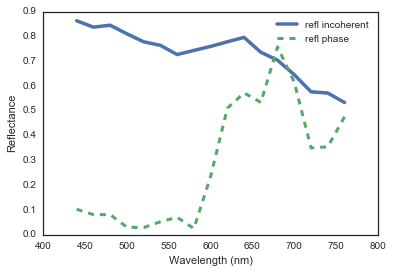

In [10]:
# compare incoherent reflectance to coherent reflectance
sns.set_style('white')
plt.figure()
plt.plot(wavelengths, reflectance , label = 'refl incoherent', linewidth = 3.5)
plt.plot(wavelengths, refl_phase*40000,'--', label = 'refl phase', linewidth = 3)
plt.xlim([400,800])
#plt.ylim([0,1])
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.legend()